# Realizando processamento no domínio da frequência e interpretação de dados magnéticos 

## Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2,ifft2,fftfreq,fftshift


In [2]:
import prism_mag

## Gerando os parâmetros das coordenadas

In [3]:
Nx = 100
Ny = 50
ymin = -1000.
ymax = 1000.
xmin = -1000.
xmax = 1000.
area = [xmin,xmax,ymin,ymax]
shape = (Nx,Ny)

In [4]:
dx = (xmax - xmin)/(Nx-1)
dy = (ymax - ymin)/(Ny-1)

In [5]:
x = np.linspace(area[0],area[1],num=Nx)
y = np.linspace(area[2],area[3],num=Ny) 
yc,xc = np.meshgrid(y,x)

In [6]:
voo = -100.
zc = voo*np.ones_like(xc)

In [7]:
coordinates = np.array([yc.ravel(),xc.ravel(),zc.ravel()])

## Gerando os parâmetros do prisma

In [8]:
intensidades = np.array([50.])

In [9]:
I,D = -2.,-2.
direcoes = np.array([[I,D]])

In [10]:
modelo = np.array([[-50.,50.,-300.,300.,300.,450.]])

## Cálculo das componentes do campo de gravidade e do potencial

In [11]:
bz = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_z")

In [12]:
bx = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_x")

In [13]:
by = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_y")

### Anomalia de campo total aproximada

In [14]:
I0,D0 = -15.,-15.
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))
tfa = j0x*bx + j0y*by + j0z*bz

### Gerando um conjunto de dados observados com ruído Gaussiano

In [15]:
np.random.seed(seed=40)
std_noise = 0.00002*np.max(np.abs(tfa))

r = np.random.normal(0.0, std_noise, tfa.size)

print ('%.3f nT' % std_noise)

0.005 nT


In [16]:
tfa_obs = tfa + r

## Visualização dos dados calculados 

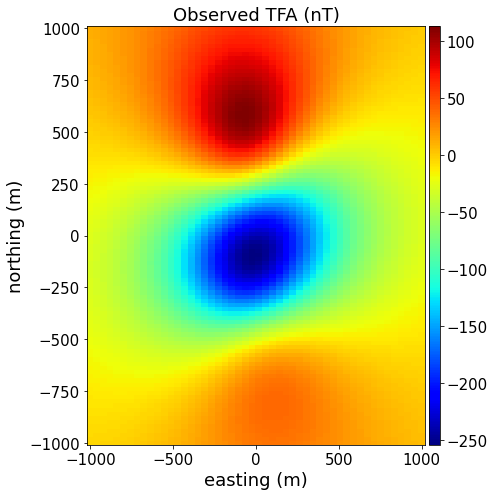

In [17]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_obs.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/observed_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

### Calculando as frequências e a transformação dos dados para o domìnio de Fourier

In [18]:
ky, kx = np.meshgrid(2*np.pi*fftfreq(Ny, dy), 2*np.pi*fftfreq(Nx, dx))

In [19]:
kz = np.sqrt(kx**2 + ky**2)

In [20]:
tfa = tfa.reshape(shape)

In [21]:
transformation = fft2(tfa)

## Realizando uma continuação para cima

In [22]:
height = 100.

In [23]:
filter_ft = np.exp(-height*kz)

In [24]:
upcont_ft = transformation*filter_ft

In [25]:
tfa_up = ifft2(upcont_ft).real

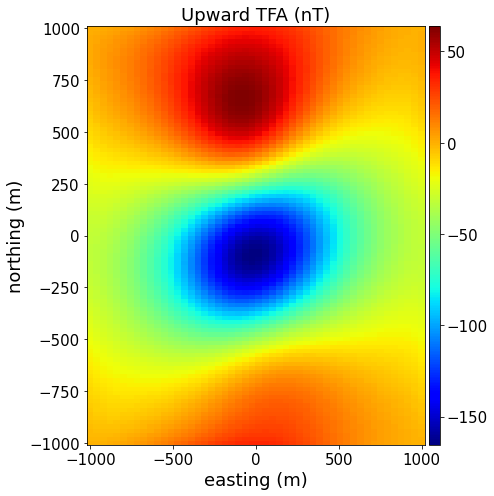

In [26]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Upward TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_up,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/upward_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

### Realizando uma redução ao polo

#### Direção do campo da Terra

In [27]:
I0,D0 = -15.,-15.
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))

#### Direção para a redução ao polo

In [28]:
Ir,Dr = -15.,-15.
mx = np.cos(np.deg2rad(Ir))*np.cos(np.deg2rad(Dr))
my = np.cos(np.deg2rad(Ir))*np.sin(np.deg2rad(Dr))
mz = np.sin(np.deg2rad(Ir))

### Aplicando a redução ao polo

In [29]:
a1 = mz*j0z - mx*j0x
a2 = mz*j0z - my*j0y
a3 = -my*j0x - mx*j0y
b1 = mx*j0z + mz*j0x
b2 = my*j0z + mz*j0y
kz_sqr = kz*kz
kx_sqr = kx*kx
ky_sqr = ky*ky

In [30]:
with np.errstate(divide='ignore', invalid='ignore'):
    filter_rtp = kz_sqr/(a1*kx_sqr + a2*ky_sqr + a3*kx*ky + 1j*kz*(b1*kx + b2*ky))
    filter_rtp[0, 0] = 0

In [31]:
tfa_reduced = transformation*filter_rtp

In [32]:
tfa_rtp = ifft2(tfa_reduced).real

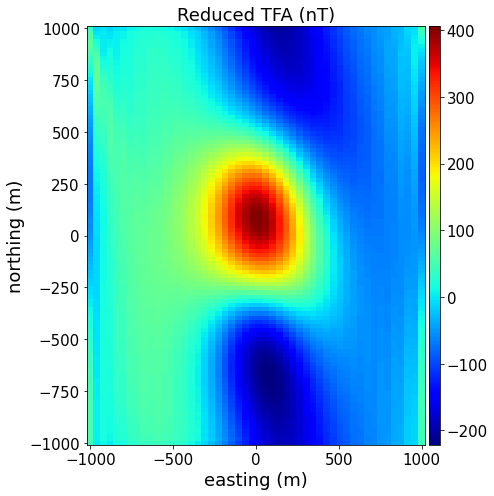

In [33]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Reduced TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_rtp,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/reduced_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

### Cálculo de derivadas primeiras

In [34]:
filter_x = 1j*kx

In [35]:
filter_y = 1j*ky

In [36]:
filter_z = kz

In [37]:
partial_x = transformation*filter_x
partial_y = transformation*filter_y
partial_z = transformation*filter_z

In [38]:
derivx = ifft2(partial_x).real
derivy = ifft2(partial_y).real
derivz = ifft2(partial_z).real

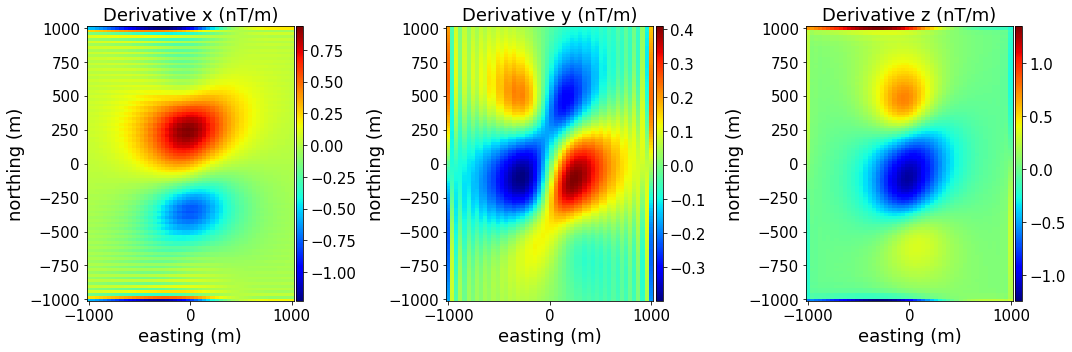

In [39]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(1,3,1)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Derivative x (nT/m)', fontsize=title_font)
plt.pcolor(yc,xc,derivx,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(1,3,2)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Derivative y (nT/m)', fontsize=title_font)
plt.pcolor(yc,xc,derivy,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(1,3,3)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Derivative z (nT/m)', fontsize=title_font)
plt.pcolor(yc,xc,derivz,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/derivatives_tfa'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

### Amplitude do gradiente total

In [40]:
tga = np.sqrt(derivx*derivx + derivy*derivy + derivz*derivz)

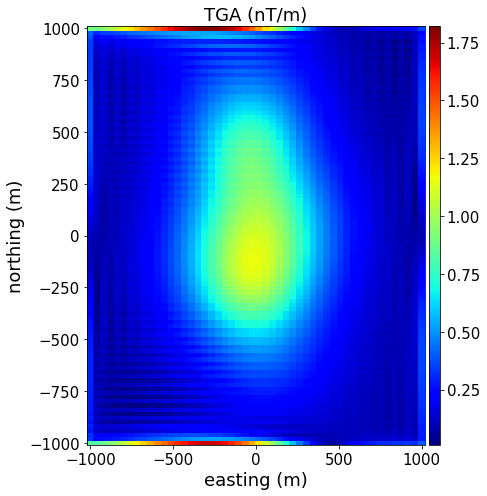

In [41]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('TGA (nT/m)', fontsize=title_font)
plt.pcolor(yc,xc,tga,shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/TGA_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()